In [1]:
import os
import json
import sys
import numpy as np
import soundfile
from torch.utils.data import Dataset
from tqdm import tqdm

from dataset import MAESTRO

## MAESTRO dataset and curated emotion annotation

In [2]:
with open("/data/MAESTRO/maestro-v2.0.0.json", "r+") as f:
    maestro_dataset = json.load(f)
with open("final_yamaha_emotion.json", "r+") as f:
    emotion_dataset = json.load(f)

In [3]:
maestro_dataset[0]

{'canonical_composer': 'Alban Berg',
 'canonical_title': 'Sonata Op. 1',
 'split': 'train',
 'year': 2018,
 'midi_filename': '2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi',
 'audio_filename': '2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav',
 'duration': 698.661160312}

In [15]:
energy = []
valence = []
cls = []
composer_title_lst_by_cls = {0: [], 1: [], 2: [], 3: []}

new_maestro_dataset = {}
for m in maestro_dataset:
    new_maestro_dataset[m["audio_filename"]] = m

for audio_filename in new_maestro_dataset.keys():
    composer_title = new_maestro_dataset[audio_filename]["canonical_composer"] + " " \
                        + new_maestro_dataset[audio_filename]["canonical_title"]
    if composer_title in emotion_dataset:
            energy.append(emotion_dataset[composer_title]["res"]["energy"])
            valence.append(emotion_dataset[composer_title]["res"]["valence"])
            cls.append(emotion_dataset[composer_title]["res"]["emotion_class"])
            
            cur_cls = emotion_dataset[composer_title]["res"]["emotion_class"]
            composer_title_lst_by_cls[cur_cls].append(composer_title)

print("Total unique title annotations:", len(emotion_dataset.keys()))
print("Total Songs:", len(new_maestro_dataset.keys()))
print("Total songs that has emotion annotations:", len(energy))

Total unique title annotations: 285
Total Songs: 1282
Total songs that has emotion annotations: 420


In [24]:
set(composer_title_lst_by_cls[0])

{'Antonio Soler Sonata No. 10 in B Minor',
 'Domenico Scarlatti Sonata in C Major, K. 513',
 'Domenico Scarlatti Sonata in C Minor, K. 84',
 'Felix Mendelssohn Etude in A Minor',
 'Franz Liszt Tarantella',
 'Franz Liszt Transcendental Etude No. 2, “Molto vivace"',
 'Frédéric Chopin Etude in F Major, Op. 10, No. 8',
 'Frédéric Chopin Polonaise Op. 53 in A-flat Major',
 'Johann Sebastian Bach English Suite No. 2  in A Minor, BWV 807, I. Prelude',
 'Johann Sebastian Bach Italian Concerto in F Major, BWV 971 (Complete)',
 'Johann Sebastian Bach Prelude and Fugue in E-flat Minor, WTC I, BWV 853',
 'Ludwig van Beethoven Variations and Fugue in E-flat Major, Op. 35, "Eroica"',
 'Wolfgang Amadeus Mozart Nine Variations, K. 264'}

Class distribution:  Counter({2: 282, 3: 105, 0: 17, 1: 16})


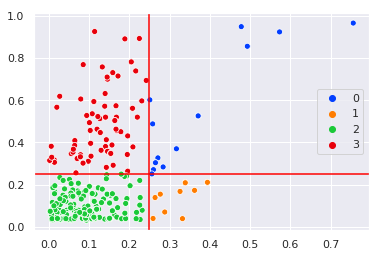

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from collections import Counter
print("Class distribution: ", Counter(cls))

palette = sns.color_palette("bright", 4)
sns.scatterplot(energy, valence, palette=palette, hue=cls)
plt.axvline(0.25, color='red')
plt.axhline(0.25, color='red')
plt.show()

## Check out some songs and onset piano roll

In [25]:
dataset = MAESTRO(path='/data/MAESTRO', groups=['train'], sequence_length=320000)

Loading group train: 100%|██████████| 677/677 [00:13<00:00, 48.75it/s]


In [29]:
from IPython.display import Audio
audio, onset_pr  = dataset[0]
Audio(audio.cpu().numpy(), rate=16000)

In [30]:
import pretty_midi

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [31]:
pr = np.pad(onset_pr.cpu().numpy(), ((0, 0), (38, 2)), "constant", constant_values=0)
pr[pr > 0] = 110
print(pr.shape)
pm = piano_roll_to_pretty_midi(pr.T)
pm.instruments[0].program = 1
x = pm.fluidsynth()
Audio(x, rate=16000)

(625, 128)
(128, 625)
0.0 110.0
